In [1]:
import numpy as np
import itertools
import pandas as pd
from scipy.stats import multivariate_normal, norm
import gurobipy as gp
from gurobipy import GRB
from IPython.display import display, Math
from gurobipy import GRB, quicksum
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product, combinations

## Balancing Weight Simulation Outline

### The proposed weighting estimator using additive balance constraints under an additive model
##### The proposed weighting estimator using balance constraints under the general additive model assumption (additive balance constraints) and covariate basis functions hs(X) = Xs, s = 1, ... , 5, 

I wrote the forms of the potential outcomes of Y1, Y2, Y3 based on the simulation setting in Section 5 and then calculate their expectations E[Y]. And then followed the Secontion 3.1.1 on the balance constrains we need to optimize using Gurobi to minimize the weighting wi. 

The balance constrains are: 

$$
\sum_{i=1}^{N} w_i A_{i \kappa}^{\Omega} h_s(\mathbf{X}_i) = \sum_{i=1}^{N} h_s(\mathbf{X}_i), \quad \text{for } \Omega = +, - \text{ and } s = 1, \dots, S,
$$

and the factors themselves and the non-negligible interactions as additional "covariates" for balancing such that

$$
\frac{1}{N} \sum_{i=1}^{N} w_i A_{i\kappa}^{\Omega} \prod_{j \in J} Z_{ij} = \frac{1}{2^{K-1}} \sum_{z \in \mathcal{Z}} g_{\kappa z}^{\Omega} \prod_{j \in J} z_j,  \text{ for } \Omega = +,- \text{ and } J \in [K]_{K'}.
$$



After optimization, extract the optimized weights and then first calculate the true factorial effects tau, which the formula is $$\tau_k = \frac{1}{2^{K-1}} \mathbf{g}_k^{\mathrm{T}} \mathbb{E}[\mathbf{Y}]$$ 

Then calculate the estimated weighted factorial effects tua_hat in the Section 2.2 where 


we need to assign a weight of $w_{Z_i}(\mathbf{X}_i)$ to the observed outcome of individual i, determined by the specific treatment combination they received.

Let $w_i = N w_{Z_i}(\mathbf{X}_i)/(2^{K-1} N_{Z_i})$ denote the normalized weights, and let

$$A_{i\kappa}^{+} = \sum_{z \in \mathcal{Z}} g_{\kappa z}^{+} I(Z_i = z), A_{i\kappa}^{-} = \sum_{z \in \mathcal{Z}} g_{\kappa z}^{-} I(Z_i = z) = 1 - A_{i\kappa}^{+}$$

denote whether individual i belongs to the positive or negative part of contrast $\mathbf{g}_\kappa$, respectively.


We estimate the factorial effect $\tau_\kappa$ with the weighting estimator: $\hat{\tau}_\kappa = \hat{\tau}_\kappa^{+} - \hat{\tau}_\kappa^{-}$ , where $$\hat{\tau}_\kappa^{\Omega} = \frac{1}{N} \sum_{i=1}^{N} w_i A_{i\kappa}^{\Omega} Y_i^{\text{obs}}, \quad \text{for } \Omega = +, -.$$

Lastly, calculte the RMSE which The RMSE is calculated as the square root of the average of $(\hat\tau-\tau)^2$.


### The proposed weighting estimator with treatment effect Heterogeneity: incorporates interaction balance constraints
The proposed weighting estimator using balance constraints under the outcome model assumption with treatment effect heterogeneity (interaction balance constraints) and the same set of basis functions as the genearl additive model.




I wrote the forms of the potential outcomes of Y1, Y2, Y3 based on the simulation setting in Section 5 and then calculate their expectations E[Y]. And then followed the Secontion 3.1.1 on the balance constrains we need to optimize using Gurobi to minimize the weighting wi.
 
The balancing constrains are: 
$$
\sum_{i=1}^{N} w_i A_{i \kappa}^{\Omega} \mathbf{q}(\mathbf{X}_i, \mathbf{Z}_i) = \frac{1}{2^{K-1}} \sum_{\mathbf{z} \in \mathcal{Z}} g_{\kappa \mathbf{z}}^{\Omega} \sum_{i=1}^{N} \mathbf{q}(\mathbf{X}_i, \mathbf{z}), \quad \text{for } \Omega = +, -.
$$

After optimization, extract the optimized weights and then first calculate the true factorial effects tau, which the formula is $$\tau_k = \frac{1}{2^{K-1}} \mathbf{g}_k^{\mathrm{T}} \mathbb{E}[\mathbf{Y}]$$

Then calculate the estimated weighted factorial effects tua_hat as the formula shown in the Section 2.2 like the ones above: 

We estimate the factorial effect $\tau_\kappa$ with the weighting estimator: $\hat{\tau}_\kappa = \hat{\tau}_\kappa^{+} - \hat{\tau}_\kappa^{-}$ , where $$\hat{\tau}_\kappa^{\Omega} = \frac{1}{N} \sum_{i=1}^{N} w_i A_{i\kappa}^{\Omega} Y_i^{\text{obs}}, \quad \text{for } \Omega = +, -.$$

Lastly, calculte the RMSE which The RMSE is calculated as the square root of the average of $(\hat\tau-\tau)^2$.

## Simulation Details

### Limitations (fixed)

The issue I had before is solved! Now there is no need for allowing approximate balance. 

Before, I messed up on the solve_weights_heterogeneous() function where the main cause is that my balance constraints are incorrectly forcing each subgroup $(Z_k = +1) and (Z_k = -1)$ to exactly match the entire sample’s sum of each basis dimension. That’s almost always impossible (or leads to extreme/degenerate solutions) when $(w_i \geq 0)$. Specificly, for each factor $k$ and each basis column $t$, I enforced $\sum_i w_i A_{i,\kappa}^{\Omega} Q[i,t] = \sum_i Q[i,t]$.  
This is wrong because I forgot to add the term $\frac{1}{2^{K-1}} \sum_{z \in \mathcal{Z}} g^{\Omega}_{\mathcal{K}z}$ on the right side of the balance constraints. Consequently, Gurobi can only finds infeasible models and produce $\text{nan}$ outputs.


### The New Results

The RMSE outputs for estimating three main effects using the four estimators: Regression(additive), Regresstion(interaction), Weighting(additive), Weighting(interaction) and the standardized mean differences(SMD) for checking whether covariate balance is achieved as required by the balance constraints. 

In [28]:
np.random.seed(123)

n_sims = 100 # number of repetitions
N = 1000 # sample size
D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)
# constructs a covariance matrix where diagonal elements are 1 and off-diagonal elements are rho.
# when rho = 0.0, Sigma is an identity matrix, meaning all covariates are independent.

# coefficient vectors for generating Z 
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

# Estimate tau_1, tau_2, tau_3 under each outcome model.

# implements the logistic function for probability calculations
def logistic(x): 
    return 1.0 / (1.0 + np.exp(-x))

def generate_treatments(X):
    # initializes a Z matrix (N x K) where each row represents an individual's treatment status.
    Z = np.zeros((X.shape[0], K)) 
    # computes treatment probabilities using logistic regression.
    p1 = logistic(X @ beta1)
    # assigns +1 or -1 tp Z1, Z2, Z3 based on these probabilities p1, p2, p3
    Z1 = (np.random.rand(X.shape[0]) < p1).astype(int)*2 - 1
    Z[:, 0] = Z1

    p2 = logistic(X @ beta2)
    Z2 = (np.random.rand(X.shape[0]) < p2).astype(int)*2 - 1
    Z[:, 1] = Z2

    p3 = logistic(X @ beta3)
    Z3 = (np.random.rand(X.shape[0]) < p3).astype(int)*2 - 1
    Z[:, 2] = Z3

    return Z

def make_contrast_vectors(K):
    # generates all 2^K possible combinations of treatments, each treatment can be -1 or +1
    combos = np.array(list(product([-1,1], repeat=K)))  # shape (8,3)
    # main-effect vectors
    # creates contrast vectors for each treatment
    g = {}
    for k in range(K):
        # assigns +1 if the treatment is +1, otherwise assigns -1
        gk = np.where(combos[:, k] == +1, +1, -1) 
        g[k+1] = gk

    return g, combos

g_dict, Z_all = make_contrast_vectors(K)  # Z_all is shape (8,3), the matrix of all possible treatment assignments


def true_main_effects(Yfn, combos=Z_all):
    # generates a large population (bigN = 200000) for estimating expected treatment effects
    bigN = 200000  
    # generates samples from a multivariate normal distribution with mean vector [0, 0, 0, 0, 0]
    Xbig = np.random.multivariate_normal(np.zeros(D), Sigma, size=bigN) 
    # match the simulation in section 5.1 where mu = (0.1, 0.1, 0.1, 0, 0).T
    Xbig[:,0] += 0.1
    Xbig[:,1] += 0.1
    Xbig[:,2] += 0.1
    
    # store expected outcomes for each treatment combination
    EYZ = np.zeros(len(combos)) 
    for i,z in enumerate(combos):
        # expands z across bigN rows
        Zbig = np.tile(z, (bigN, 1))  # shape (bigN,3)
        # computes expected outcomes for treatment z using function Yfn(Xbig, Zbig).
        Evals = Yfn(Xbig, Zbig)       # now shape (bigN,)
        # stores the mean outcome for each treatment condition
        EYZ[i] = np.mean(Evals)

    tau = {}
    factor = 1 / (2 ** (K - 1))  # Compute the factor for scaling
    for k in range(1, K+1):
        # retrieves contrast vector for the k-th treatment.
        gk = g_dict[k]
        # computes the main effect estimate
        #tau_k = np.mean(gk * EYZ)  
        tau_k = factor * np.dot(gk, EYZ)  
        tau[k] = tau_k
    return tau


def Y_model_additive(X, Z):
    sumX = 2 * np.sum(X, axis=1)  # factor 2
    sumZ = np.sum(Z, axis=1)
    return sumX + sumZ

def Y_model_het(X, Z):
    sumX = np.sum(X, axis=1)*2.0
    sumZ = np.sum(Z, axis=1)
    return sumX + (np.sum(X, axis=1)*sumZ)

def Y_model_mis(X, Z):
    X1 = X[:,0]
    X2 = X[:,1]
    part1 = np.sin(X1) + np.cos(X2)
    part2 = (np.minimum(1.0, X1) + X2) * Z[:,0]
    # sum_i(X_i) * sum_{j=2..3}(Z_j)
    part3 = np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)
    return part1 + part2 + part3

def simulate_Y(X, Z, model="additive"):
    if model=="additive":
        meanY = Y_model_additive(X, Z)
    elif model=="heterogeneous":
        meanY = Y_model_het(X, Z)
    elif model=="misspecified":
        meanY = Y_model_mis(X, Z)
    else:
        raise ValueError("Unknown model")
    return meanY + np.random.randn(len(X))  # add normal(0,1)


def solve_weights_additive(X, Z):
    N, D = X.shape

    # Build A^+_{i,k} and A^-_{i,k}, splits the dataset into two groups based on Z
    # For main effect k, A^+_{i,k} = 1 if Z_{i,k} = +1, else 0
    Aplus = np.where(Z>0, 1.0, 0.0)   # shape (N,K)
    Aminus= 1.0 - Aplus              # shape (N,K)

    # Computes the sum of each covariate across all individuals, ensures covariate balance across treatment groups.
    sumX = np.sum(X, axis=0)  # shape (D,)

    # Start building the model
    model = gp.Model("AdditiveBalance")
    model.setParam('OutputFlag', 0)  

    # Creates N weight variables w_i, one for each individual, lb=0.0 ensures non-negative weights
    w_vars = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0.0, name="w")

    # minimize sum_i w_i^2
    obj = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))
    model.setObjective(obj, GRB.MINIMIZE)

    # add constraints
    # sum_i w_i * Aplus[i,k] * X[i,d] = sumX[d]
    # sum_i w_i * Aminus[i,k]* X[i,d] = sumX[d]
    # This ensures that the sum of covariates matches in treatment and control groups
    for k_ in range(K):
        for d_ in range(D):
            lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]*X[i,d_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_]*X[i,d_] for i in range(N))
            model.addConstr(lhs_plus  == sumX[d_])
            model.addConstr(lhs_minus == sumX[d_])

    # factor-balance constraints, it maks sure that the total weight of each subgroup is exactly N
    for k_ in range(K):
        lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]  for i in range(N))
        lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_] for i in range(N))
        model.addConstr(lhs_plus  == N)
        model.addConstr(lhs_minus == N)

    # Iterate over all interaction terms up to order K'
    K_prime = min(K, 2)  # set K prime as 2

    for k_size in range(2, K_prime + 1):  # actually only considerting K prime = 2
        for J in combinations(range(K), k_size):  # each J is a tuple representing a combination of treatment indices
            # eg. [(0, 1), (0, 2), (1, 2)], it is the interaction terms we need

            # Compute the product of Z interactions across J for each individual to get the interaction outputs
            Z_interaction = np.prod(Z[:, J], axis=1)

            # Left-hand side: weighted sum of the interaction terms across all subjects in the actual treatment assignments
            lhs_interaction = gp.quicksum(w_vars[i] * Z_interaction[i] for i in range(N))

            factor = 1 / (2 ** (K - 1))
            # computes interaction terms across all possible treatment assignments
            g_interaction = np.prod(Z_all[:, J], axis=1)  # shape (2^K,) 
            # Right-hand side: weighted sum over the interaction terms across all treatment assignments
            rhs_interaction = factor * np.sum(g_interaction * 1.0)

            # Add the balance constraint
            model.addConstr(lhs_interaction == rhs_interaction)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("Model did not find an optimal solution!")
        return None
    
    # extract the weight w_opt
    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

def solve_weights_heterogeneous(X, Z):
    model = gp.Model("HeteroExact")
    model.setParam('OutputFlag', 0)

    w_vars = model.addVars(N, lb=0.0, name="w")

    # Define basis functions q_s^J: 
    basis_vals = []
    basis_vals.append(np.ones(N))  # the intercept column
    for d_ in range(D):
        basis_vals.append(X[:, d_]) # each covariate X_d is added 

    J_list = [()] + [(j,) for j in range(K)] # contains empty sets and single-factor interactions
    n_s = len(basis_vals)
    n_J = len(J_list)

    # Compute q_s^J(X_i, Z_i) and store it in Qvals[N, n_s, n_J] for actual treatment assignments Z
    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J_ in enumerate(J_list):
        if len(J_) == 0: # if J_ is empty, no multiplication by Z, it returns the basis function h_s(X)
            Zp = np.ones(N)
        else:
            # it multiplies h_s(X) by the corresponding treatment factors Z_k
            Zp = np.prod(Z[:, J_], axis=1) # Zp = ∏_{j in J_} Z[:, j], shape (N,)
    
        for s_ in range(n_s):
            Qvals[:, s_, j_idx] = basis_vals[s_] * Zp

   
    # Build A^+_{i,k} and A^-_{i,k} for main effects
    def gk_plus(z, k_):
        return 1.0 if z[k_] == +1 else 0.0

    def gk_minus(z, k_):
        return 1.0 if z[k_] == -1 else 0.0


    # Precompute sums of q_s^J(X_i, z) for every treatment assignments Z_all
    bigQ = np.zeros((len(Z_all), n_s, n_J))
    for j_idx, J_ in enumerate(J_list):
        for s_ in range(n_s):
            for z_index, z_ in enumerate(Z_all):
                z_prod = np.prod(z_[list(J_)]) # compute the product ∏_{j in J_} z_j
                # the sum of the basis function over all individuals multiplied by the product of the relevant factors in z_ 
                bigQ[z_index, s_, j_idx] = z_prod * np.sum(basis_vals[s_]) 

    # For each individual, Aplus[i,k] = 1 if Z[i,k] = +1 else 0
    Aplus = np.zeros((N, K))
    Aminus = np.zeros((N, K))
    for i in range(N):
        for k_ in range(K):
            Aplus[i, k_]  = 1.0 if Z[i, k_] == +1 else 0.0
            Aminus[i, k_] = 1.0 if Z[i, k_] == -1 else 0.0


    # Defining main effect targets
    factor = 1.0 / (2.0 ** (K - 1))
    target_plus = np.zeros((K, n_s, n_J))
    target_minus = np.zeros((K, n_s, n_J))

    for k_ in range(K):
        for z_index, z_ in enumerate(Z_all):
            coeff_plus  = gk_plus(z_, k_)
            coeff_minus = gk_minus(z_, k_)
            for s_ in range(n_s):
                for j_idx in range(n_J):
                    # store the desired weighted sum for the +1 and -1 group of factor k_ for a basis dimension s_ and factor combination j_idx.
                    target_plus[k_, s_, j_idx]  += factor * coeff_plus  * bigQ[z_index, s_, j_idx]
                    target_minus[k_, s_, j_idx] += factor * coeff_minus * bigQ[z_index, s_, j_idx]
                    # it tells how large the weighted sum of q_s^J(X_i, Z_i) should be in the +1 and -1 groups of factor k_ if we want perfect balance


    # minimize sum_i w_i^2
    obj = gp.QuadExpr()
    for i in range(N):
        obj += w_vars[i]*w_vars[i]

    # Add the constraints:
    for k_ in range(K):
        for s_ in range(n_s):
            for j_idx in range(n_J):
                # LHS^+_k
                lhs_plus = gp.quicksum(Aplus[i, k_] * Qvals[i, s_, j_idx] * w_vars[i] for i in range(N))
                model.addConstr(lhs_plus == target_plus[k_, s_, j_idx])

                # LHS^-_k
                lhs_minus = gp.quicksum(Aminus[i, k_] * Qvals[i, s_, j_idx] * w_vars[i] for i in range(N))
                model.addConstr(lhs_minus == target_minus[k_, s_, j_idx])

    # Set objective and solve
    model.setObjective(obj, GRB.MINIMIZE)
    model.optimize()

    # Check feasibility
    #print("Solver status:", model.status)
    if model.status != GRB.OPTIMAL:
        return None

    # Extract solution
    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

def estimate_main_effects_weighted(Y, X, Z, w):
    Aplus = (Z>0).astype(float)   # shape (N,K)
    Aminus= 1.0 - Aplus

    tau_est = {}
    for k_ in range(K):
        # Computes the weighted average of outcomes for the treatment group
        # \hat{tau}^+_k = (1/N) sum_i w_i A^+_{i,k} Y_i
        tau_plus = np.sum(w * Aplus[:,k_] * Y) / N
        tau_minus= np.sum(w * Aminus[:,k_] * Y) / N
        tau_est[k_+1] = tau_plus - tau_minus
    return tau_est


def additive_regression(Y, X, Z):
    N = len(Y)
    # design: intercept + X + Z (K columns)
    Xd = np.column_stack([np.ones(N), X, Z])
    model = sm.OLS(Y, Xd).fit()
    # The last K coefficients correspond to Z.  Actually the indexing depends on shape(D).
    # intercept: 0, X: 1..D, Z: D+1..D+K
    coefs = model.params
    out = {}
    for k_ in range(K):
        zcoef = coefs[D+1 + k_]
        out[k_+1] = 2*zcoef
    return out

def interaction_regression(Y, X, Z):
    N = len(Y)
    # Build design:
    # columns: 1, X (D of these), Z (K of these), then X_j * Z_k for each j,k
    design_list = []
    design_list.append(np.ones(N))  # intercept
    for d_ in range(D):
        design_list.append(X[:, d_])
    for k_ in range(K):
        design_list.append(Z[:, k_])
    # add interactions X_j * Z_k
    for d_ in range(D):
        for k_ in range(K):
            design_list.append(X[:, d_] * Z[:, k_])
    Xd = np.column_stack(design_list)

    model = sm.OLS(Y, Xd).fit()
    coefs = model.params

    # The main‐effect coefficient for factor k_ is among the first (1 + D + K) terms (the portion for Z_k).
    out = {}
    for k_ in range(K):
        zcoef = coefs[D + 1 + k_]
        out[k_+1] = 2*zcoef
    return out

# Getting the standardized mean difference (SMD) for each factor k and each covariate dimension d
def get_covariate_balance(X, Z, w, label="Additive"):

    # Overall (unweighted) standard deviation of each covariate
    sd_X = np.std(X, axis=0, ddof=1)  # shape (D,)

    smd = np.zeros((K, D))

    for k_ in range(K):
        # Mask for plus/minus
        plus_mask  = (Z[:, k_] == +1)
        minus_mask = (Z[:, k_] == -1)

        w_plus_sum  = np.sum(w[plus_mask])
        w_minus_sum = np.sum(w[minus_mask])

        # Weighted mean of X[:, d_] in the plus group
        x_plus_mean  = np.sum(w[plus_mask, None]  * X[plus_mask],  axis=0) / (w_plus_sum  + 1e-15)
        # Weighted mean in the minus group
        x_minus_mean = np.sum(w[minus_mask, None] * X[minus_mask], axis=0) / (w_minus_sum + 1e-15)

        diff = x_plus_mean - x_minus_mean

        for d_ in range(D):
            if sd_X[d_] < 1e-15:
                smd[k_, d_] = 0.0  
            else:
                smd[k_, d_] = diff[d_] / sd_X[d_]

    return smd

# print an array with 5 significant figures per float.
def print_array_5sig(arr):
    with np.printoptions(formatter={'float_kind': lambda x: f"{x:.5g}"}):
        print(arr)

def run_simulation(n_sims=100, N=2000, model_type="additive"):
    # For storing results
    tauhats_addreg  = []
    tauhats_intreg  = []
    tauhats_weightA = []  
    tauhats_whet    = []
    smds_add = []
    smds_het = []

    if model_type == "additive":
        Yfn = Y_model_additive
    elif model_type == "heterogeneous":
        Yfn = Y_model_het
    elif model_type == "misspecified":
        Yfn = Y_model_mis
    else:
        raise ValueError("Unknown model_type")
    
    true_tau = true_main_effects(Yfn)

    for sim in range(n_sims):
        # generate X
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0]).T
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)

        # generate Z
        Z_ = generate_treatments(Xraw)

        # simulate Y
        Y_ = simulate_Y(Xraw, Z_, model=model_type)

        # 1) additive regression
        est_ar = additive_regression(Y_, Xraw, Z_)
        tauhats_addreg.append([est_ar[1], est_ar[2], est_ar[3]])

        # 2) interaction regression
        est_ir = interaction_regression(Y_, Xraw, Z_)
        tauhats_intreg.append([est_ir[1], est_ir[2], est_ir[3]])

        # 3) weighting (additive constraints)
        wA = solve_weights_additive(Xraw, Z_)
        #print(wA)
        if wA is None:
            # if solver failed, just skip
            tauhats_weightA.append([np.nan, np.nan, np.nan])
            smds_add.append(np.full((K, D), np.nan))
        else:
            estA = estimate_main_effects_weighted(Y_, Xraw, Z_, wA)
            tauhats_weightA.append([estA[1], estA[2], estA[3]])
            smd_add = get_covariate_balance(Xraw, Z_, wA)
            smds_add.append(smd_add)

        # 4) weighting (interaction constrains)
        wH = solve_weights_heterogeneous(Xraw, Z_)
        #print(wH)
        if wH is None:
            tauhats_whet.append([np.nan, np.nan, np.nan])
            smds_het.append(np.full((K, D), np.nan))
        else:
            estH = estimate_main_effects_weighted(Y_, Xraw, Z_, wH)
            tauhats_whet.append([estH[1], estH[2], estH[3]])
            smd_het = get_covariate_balance(Xraw, Z_, wH)
            smds_het.append(smd_het)
            

    # Convert to arrays
    smds_add = np.array(smds_add)  
    smds_het = np.array(smds_het) 
    tauhats_addreg  = np.array(tauhats_addreg)
    tauhats_intreg  = np.array(tauhats_intreg)
    tauhats_weightA = np.array(tauhats_weightA)
    tauhats_whet    = np.array(tauhats_whet)

    # RMSE
    rmse_ar = np.sqrt(np.mean((tauhats_addreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_ir = np.sqrt(np.mean((tauhats_intreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wa = np.sqrt(np.nanmean((tauhats_weightA- [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wh = np.sqrt(np.nanmean((tauhats_whet - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))

    # SMDs (average across simulation runs)
    mean_smd_add = np.nanmean(smds_add, axis=0)  
    mean_smd_het = np.nanmean(smds_het, axis=0)  

    return {
        'true_tau': true_tau,
        'rmse_additive_regression': rmse_ar,
        'rmse_interaction_regression': rmse_ir,
        'rmse_weighting_additive': rmse_wa,
        'rmse_weighting_hetero':  rmse_wh,
        'mean_smd_add': mean_smd_add,
        'mean_smd_het': mean_smd_het
    }


if __name__=="__main__":
    # Example usage: run each model type
    for mtype in ["additive","heterogeneous","misspecified"]:
        res = run_simulation(n_sims=n_sims, N=N, model_type=mtype)
        print(f"\nModel type = {mtype}")
        print("True main effects:", res['true_tau'])
        print("RMSE (add. regression):",    res['rmse_additive_regression'])
        print("RMSE (inter. regression):",  res['rmse_interaction_regression'])
        print("RMSE (weighting add.):",     res['rmse_weighting_additive'])
        print("RMSE (Weight Hetero.):",  res['rmse_weighting_hetero'])
        print("\nMean SMD (Additive Weights):")
        print_array_5sig(res['mean_smd_add'])
        print("\nMean SMD (Hetero Weights):")
        print_array_5sig(res['mean_smd_het'])



Model type = additive
True main effects: {1: np.float64(2.0), 2: np.float64(2.0), 3: np.float64(2.0)}
RMSE (add. regression): [0.07160701 0.07478839 0.07181999]
RMSE (inter. regression): [0.07497135 0.07660735 0.07293965]
RMSE (weighting add.): [0.0957313  0.09085465 0.08905734]
RMSE (Weight Hetero.): [0.0975     0.09128872 0.0904975 ]

Mean SMD (Additive Weights):
[[-1.7545e-17 -7.5933e-18 -2.0226e-17 7.0045e-18 -1.8796e-17]
 [1.1783e-18 2.2805e-17 2.2159e-17 -7.6698e-18 -2.2029e-17]
 [1.2603e-17 1.1279e-17 7.8385e-18 -9.3637e-18 -1.3868e-17]]

Mean SMD (Hetero Weights):
[[-1.6837e-16 1.8634e-16 -2.9991e-17 -2.4516e-16 -3.5686e-18]
 [-1.7176e-18 1.5447e-17 1.1057e-16 3.9315e-17 3.3279e-17]
 [1.3969e-17 -1.1167e-16 -1.0426e-16 -1.0038e-16 2.4539e-16]]

Model type = heterogeneous
True main effects: {1: np.float64(0.6033841307300947), 2: np.float64(0.6033841307300947), 3: np.float64(0.6033841307300947)}
RMSE (add. regression): [0.27448412 0.46010381 0.38394254]
RMSE (inter. regression):

##### The Mean SMDs of the Additive and Hetero Weights from the three outcome models are all close to 0.

#### Plot of the root mean squared error (RMSE) for estimating three main effects over 100 repetitions using four estimators when N = 1000 and $\rho$ = 0

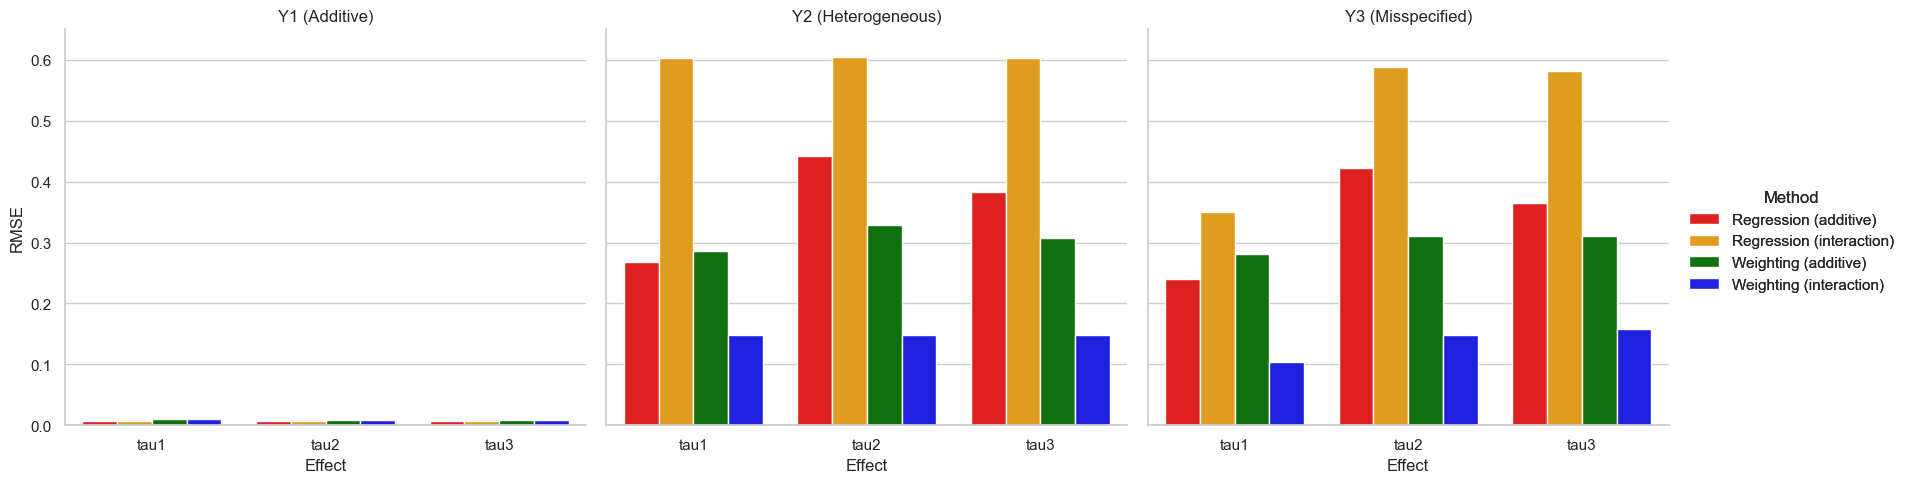

In [3]:
def plot_rmse_comparison_approx(results_dict):
    effects = ['tau1', 'tau2', 'tau3']
    models = {"additive": "Y1 (Additive)", "het": "Y2 (Heterogeneous)", "mis": "Y3 (Misspecified)"}
    
    data = []
    for model_type, rmse_vals in results_dict.items():
        for method, values in rmse_vals.items():
            for i, val in enumerate(values):
                data.append([models[model_type], effects[i], val, method])

    df = pd.DataFrame(data, columns=["Outcome Model", "Effect", "RMSE", "Method"])
    
    # Set style
    sns.set(style="whitegrid")

    # Create FacetGrid bar plot
    g = sns.catplot(
        data=df,
        x="Effect",
        y="RMSE",
        hue="Method",
        col="Outcome Model",
        kind="bar",
        palette=['red', 'orange', 'green', 'blue'],
        height=5,
        aspect=1
    )

    g.set_axis_labels("Effect", "RMSE")
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=0)
    g.add_legend(title="Method")
    g.set(ylim=(0, 0.65))
    
    plt.show()

results_dict = {}

results_dict = {
    "additive": {
        "Regression (additive)": [0.0071607, 0.00747884, 0.007182],
        "Regression (interaction)": [0.00749714, 0.00766074, 0.00729396],
        "Weighting (additive)": [0.00957313, 0.00908547, 0.00890573],
        "Weighting (interaction)": [0.00975, 0.00912887, 0.00904975]
    },
    "het": {
        "Regression (additive)": [0.26884906, 0.44287349, 0.38333178],
        "Regression (interaction)": [0.60348814, 0.60412359, 0.6033029],
        "Weighting (additive)": [0.2865843, 0.32954693, 0.30674729],
        "Weighting (interaction)": [0.14881196, 0.14828785, 0.14750694]
    },
    "mis": {
        "Regression (additive)": [0.24024016, 0.42220238, 0.36515148],
        "Regression (interaction)": [0.34999569, 0.58785923, 0.58230781],
        "Weighting (additive)": [0.28078339, 0.31040218, 0.30997795],
        "Weighting (interaction)": [0.10361244, 0.14793751, 0.15812194]
    }
}

plot_rmse_comparison_approx(results_dict)

## Matching Method Simulation

#### Transform the current weighting approach into a matching approach. 

The idea is that: 
1. Solve for weights as usual.

2. Threshold those weights to get a 0/1 indicator:

$$
match_i = \begin{cases}
1 & \text{if } w_i < \text{threshold},\\
0 & \text{otherwise}.
\end{cases}
$$

3. Interpret $match_i = 1$ as “include subject $i$” in the matched sample, and $match_i = 0$ as “exclude subject $i$.”

Below I used a threshold $0.001$.


In [ ]:
np.random.seed(123)

n_sims = 100  # number of repetitions
N = 200      # sample size
D = 5         # number of covariates
K = 3         # number of binary covariates
rho = 0.0     # correlation among covariates
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)

# Coefficients for generating Z
beta1 = np.array([1/4, 2/4, 0.0, 3/4, 1.0])
beta2 = np.array([3/4, 1/4, 1.0, 0.0, 2/4])
beta3 = np.array([1.0, 0.0, 3/4, 2/4, 1/4])

def solve_weights_additive_match(X, Z, threshold=1e-6):
    w_opt = solve_weights_additive(X, Z)
    #print(w_opt)
    if w_opt is None:
        return None  # infeasible
    
    # if w_opt < threshold, match_vec[i] = 1, otherwise 0
    match_vec = (w_opt < threshold).astype(int)
    return match_vec

def solve_weights_heterogeneous_match(X, Z, threshold=1e-6):
    w_opt = solve_weights_heterogeneous(X, Z)
    #print(w_opt)
    if w_opt is None:
        return None
    match_vec = (w_opt < threshold).astype(int) 
    return match_vec

#  do naive difference in means for each factor, the estimated factorial effect
def naive_diff_in_means(Y, Z, match_vec):
    # Weighted means become simple means if match_vec is 0/1
    # tau_k = mean(Y | Z_k=+1 & matched) - mean(Y | Z_k=-1 & matched)
    tau = {}
    for k_ in range(K):
        plus_mask  = (Z[:, k_] == +1) & (match_vec == 1)
        minus_mask = (Z[:, k_] == -1) & (match_vec == 1)
        if np.sum(plus_mask) < 1 or np.sum(minus_mask) < 1:
            tau[k_+1] = np.nan
        else:
            mean_plus  = np.mean(Y[plus_mask])
            mean_minus = np.mean(Y[minus_mask])
            tau[k_+1] = mean_plus - mean_minus
    return tau


def run_simulation_matching(n_sims=10, N=1000, model_type="additive", threshold=1e-6):

    if model_type == "additive":
        Yfn = Y_model_additive
    elif model_type == "heterogeneous":
        Yfn = Y_model_het
    elif model_type == "misspecified":
        Yfn = Y_model_mis
    else:
        raise ValueError("Unknown model_type")

    true_tau = true_main_effects(Yfn)

    matched_taus_add = []
    matched_taus_het = []

    for sim in range(n_sims):
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)
        Z_   = generate_treatments(Xraw)
        Y_   = simulate_Y(Xraw, Z_, model=model_type)

        # Solve for 0/1 match vectors
        matchA = solve_weights_additive_match(Xraw, Z_, threshold=threshold)
        matchH = solve_weights_heterogeneous_match(Xraw, Z_, threshold=threshold)
        #print(matchA)
        #print(matchH)

        if matchA is None:
            matched_taus_add.append([np.nan, np.nan, np.nan])
        else:
            tA = naive_diff_in_means(Y_, Z_, matchA)
            matched_taus_add.append([tA[1], tA[2], tA[3]])

        if matchH is None:
            matched_taus_het.append([np.nan, np.nan, np.nan])
        else:
            tH = naive_diff_in_means(Y_, Z_, matchH)
            matched_taus_het.append([tH[1], tH[2], tH[3]])

    # Convert to arrays
    matched_taus_add = np.array(matched_taus_add)
    matched_taus_het = np.array(matched_taus_het)

    def rmse(vals, truth):
        return np.sqrt(np.nanmean((vals - truth)**2, axis=0))

    # shape (n_sims, 3) => compare to [true_tau[1], true_tau[2], true_tau[3]]
    add_rmse = rmse(matched_taus_add, [true_tau[1], true_tau[2], true_tau[3]])
    het_rmse = rmse(matched_taus_het, [true_tau[1], true_tau[2], true_tau[3]])

    return {
        "true_tau": true_tau,
        "rmse_matched_additive": add_rmse,
        "rmse_matched_hetero":   het_rmse
    }




=== Matching approach, model_type=additive ===
True main effects: {1: np.float64(2.0), 2: np.float64(2.0), 3: np.float64(2.0)}
RMSE (matched additive): [ 9.94824507 11.66617831 11.90739694]
RMSE (matched hetero.): [ 9.72174761 11.31959594 11.62955719]


KeyboardInterrupt: 

In [ ]:
if __name__ == "__main__":
    for mtype in ["additive", "heterogeneous", "misspecified"]:
        res = run_simulation_matching(n_sims=n_sims, N=N, model_type=mtype, threshold=1)
        print(f"\n=== Matching approach, model_type={mtype} ===")
        print("True main effects:", res["true_tau"])
        print("RMSE (matched additive):",   res["rmse_matched_additive"])
        print("RMSE (matched hetero.):",    res["rmse_matched_hetero"])

#### Plot of the root mean squared error (RMSE) for estimating three main effects over 100 repetitions using two estimators matched additive and matched heterogeneous when N = 1000 and $\rho$ = 0